In [223]:
#%reset

# MINI-PROYECTO 5 - FALLAS EN FABRICACION DE LAMINAS DE ACERO CON NN
Julian Augusto Cortes Gomez


Angela Hurtado

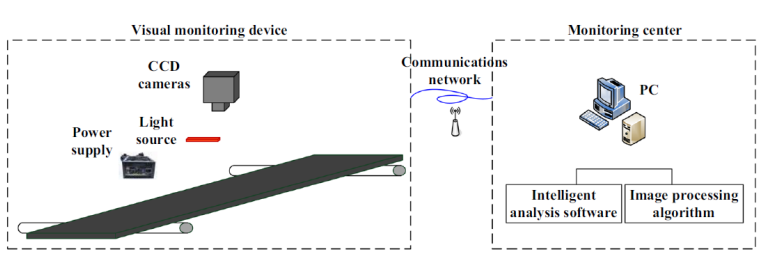



# Librerias

In [224]:
from google.colab import drive
drive.mount("/content/gdrive")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import missingno as msno
from collections import Counter
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
###################
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from yellowbrick.model_selection import RFECV
from sklearn.feature_selection import RFE
import joblib
import re
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
!pip install autokeras
import autokeras as ak
from autokeras import StructuredDataClassifier

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Funcion Matriz de Confusion
Se define una funcion capaz de generar matrices de confusion muy esteticas y con mas informacion que un heatmap, con unos cuantos parametros de entrada.

In [225]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

# Funcion de Correlacion

In [226]:
def high_cor_function(df , th ):
    cor = df.corr()
    corrm = np.corrcoef(df.transpose())
    corr = corrm - np.diagflat(corrm.diagonal())
    print("max corr:",corr.max(), ", min corr: ", corr.min())
    c1 = cor.stack().sort_values(ascending=False).drop_duplicates()
    high_cor = c1[c1.values!=1]    
    thresh = th
    display(high_cor[high_cor>thresh])

# Primer vistazo al dataset
Vemos que existen muchas cosas para cambiar, emepzando por el formato de lagunos titulos, el tipo de dato en algunas columnas, y ademas de eso añadir unas variables dummies a tipo de acero y otras variables categoricas.

In [227]:
df = pd.read_csv("/content/gdrive/MyDrive/Datos_MP_5.csv", sep = ";")
df.head(10)

,Tipo_Falla,Tipo de Acero,X_min,X_max,Y_min,Y_max,Factor_Area,Perimetro_X,Perimentro_Y,Luminosidad_Suma,...,Iso,Índice borde X,Índice borde Y,Índice Global externo,Ln(Índice_Areas),LN(Índice X),Ln(Índice Y),Índice de Orientación,Índice de Luminosidad,Área Sigmoide
0,Superficie Opaca,321,42,50,270900,270944,desde 256.32 hasta 275.01,17,44,24220,...,,4706,1,1.000,24265,9031,16435,8182,-2913,5822
1,Superficie Opaca,310,645,651,2538079,2538108,desde 106.92 hasta 112.32,10,30,11397,...,,6,9667,1.000,20334,7782,14624,7931,-1756,2984
2,Superficie Opaca,316,829,835,1553913,1553931,desde 69.58 hasta 72.42,8,19,7972,...,,75,9474,1.000,18513,7782,12553,6667,-1228,215
3,Superficie Opaca,431,853,860,369370,369415,desde 168.96 hasta 183.04,13,45,18996,...,,5385,1,1.000,22455,8451,16532,8444,-1568,5212
4,Superficie Opaca,403,1289,1306,498078,,desde 2312.64 hasta 2457.18,60,260,246930,...,,2833,9885,1.000,33818,12305,24099,9338,-1992,1
5,Superficie Opaca,420,430,441,100250,100337,desde 617.4 hasta 648.9,20,87,62357,...,,55,1,1.000,27993,10414,19395,8736,-2267,9874
6,Superficie Opaca,403,190,200,210936,210956,desde 126.72 hasta 135.96,11,20,20007,...,9263,9091,1,1.000,21206,1,1301,5,1841,3359
7,Superficie Opaca,431,330,343,429227,429253,desde 253.44 hasta 266.64,15,26,29748,...,,8667,1,1.000,24216,11139,1415,5,-1197,5593
8,Superficie Opaca,420,74,90,,779308,desde 1445.76 hasta 1536.12,46,167,180215,...,,3478,982,1.000,31778,12041,22148,9024,-651,1
9,Superficie Opaca,440,106,118,813452,813500,desde 437.58 hasta 455.26,13,48,50393,...,6438,9231,1,1.000,26454,10792,16812,75,-1093,8612


In [228]:
df.shape

(1935, 30)

In [229]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1935 entries, 0 to 1934
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Tipo_Falla                     1935 non-null   object 
 1   Tipo de Acero                  1935 non-null   int64  
 2   X_min                          1935 non-null   object 
 3   X_max                          1935 non-null   object 
 4   Y_min                          1935 non-null   object 
 5   Y_max                          1935 non-null   object 
 6   Factor_Area                    1935 non-null   object 
 7   Perimetro_X                    1935 non-null   int64  
 8            Perimentro_Y          1935 non-null   int64  
 9   Luminosidad_Suma               1935 non-null   int64  
 10  Luminosidad_min                1935 non-null   int64  
 11  Luminosidad_Max                1935 non-null   int64  
 12  Longitud Banda Transportadora  1935 non-null   o

# PASOS A TRATAR EN EL DATASET

*   Hay que corregir los nombres de los titulos
*   Los elementos de X Max y min al igual que Y estan en object
*   Longitud de banda, Dia, Turno, Espesor e ISO requieren tratamiento de datos
*   Existen vacancias en varias celdas, por lo que hay que hacer imputacion de datos



In [230]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df.describe()

,Tipo de Acero,Perimetro_X,Perimentro_Y,Luminosidad_Suma,Luminosidad_min,Luminosidad_Max,Índice bordes,Índice vacío,Índice cuadrático,Índice externo X,Índice borde X,Índice borde Y,Índice Global externo,Ln(Índice_Areas),LN(Índice X),Ln(Índice Y),Índice de Orientación,Índice de Luminosidad,Área Sigmoide
count,1935.000,1935.000,1935.000,1935.000,1935.000,1935.000,1935.000,1935.000,1935.000,1935.000,1935.000,1935.000,1741.000,1935.000,1935.000,1935.000,1935.000,1935.000,1935.000
mean,376.837,111.587,82.619,204932.901,84.582,130.134,3039.927,3607.666,4205.053,310.025,4310.303,3293.188,0.787,22766.210,11381.936,12594.191,683.010,-1164.371,3212.430
std,56.481,301.270,426.949,510146.540,32.109,18.623,2978.499,1890.239,3247.675,582.652,3154.279,3704.205,1.059,9642.171,6065.849,6094.689,4546.200,1453.219,3174.826
min,301.000,2.000,1.000,250.000,0.000,37.000,0.000,0.000,1.000,1.000,1.000,1.000,0.000,1.000,1.000,0.000,-9739.000,-9989.000,1.000
25%,310.000,15.000,13.000,9517.000,63.000,124.000,575.000,2546.000,875.000,59.000,875.000,1.000,0.000,18325.000,9031.000,10414.000,-1667.000,-1902.500,109.000
50%,403.000,26.000,25.000,19189.000,90.000,127.000,1812.000,3889.000,3913.000,91.000,4627.000,625.000,1.000,21553.000,11139.000,12553.000,25.000,-1147.000,2288.000
75%,420.000,83.500,83.000,82095.000,106.000,140.000,5282.000,4891.500,7120.000,199.000,6980.000,6550.000,1.000,27462.000,13979.000,17076.000,4167.000,-227.000,4963.000
max,440.000,10449.000,18152.000,11591414.000,203.000,253.000,9952.000,9439.000,9955.000,8759.000,9965.000,9994.000,5.000,51837.000,30741.000,42587.000,9917.000,6421.000,9999.000


In [231]:
df.describe(include = "O")

,Tipo_Falla,X_min,X_max,Y_min,Y_max,Factor_Area,Longitud Banda Transportadora,Día,Turno,_Espesor,Iso
count,1935,1935,1935,1935,1935,1935,1935,1935,1935,1935,1935
unique,7,929,934,1776,1634,1769,143,7,4,344,390
top,Otras Fallas,41,,,,desde 53.9 hasta 55.55,_ 1358,Jueves,Día,39.6 : 42,
freq,672,121,190,158,301,4,163,294,507,38,1542


In [232]:
df["Longitud Banda Transportadora"].value_counts()

_ 1358    163
_ 1356    130
_ 1360    102
1358       79
_ 1364     74
         ... 
_ 1324      1
1368        1
1664        1
1628        1
1710        1
Name: Longitud Banda Transportadora, Length: 143, dtype: int64

In [233]:
df["Factor_Area"].value_counts()

desde 53.9 hasta 55.55         4
desde 64.99 hasta 69.68        3
desde 176.64 hasta 189.52      3
desde 62.7 hasta 67.98         3
desde 148.8 hasta 161.2        3
                              ..
desde 6425.1 hasta 6619.8      1
desde 6110.4 hasta 6753.6      1
desde 1824.57 hasta 1879.86    1
desde 6419.16 hasta 6743.36    1
desde 410.62 hasta 423.19      1
Name: Factor_Area, Length: 1769, dtype: int64

In [234]:
df["Factor_Area"] = df["Factor_Area"].replace({'desde ':''}, regex = True)
df.head(8)

,Tipo_Falla,Tipo de Acero,X_min,X_max,Y_min,Y_max,Factor_Area,Perimetro_X,Perimentro_Y,Luminosidad_Suma,...,Iso,Índice borde X,Índice borde Y,Índice Global externo,Ln(Índice_Areas),LN(Índice X),Ln(Índice Y),Índice de Orientación,Índice de Luminosidad,Área Sigmoide
0,Superficie Opaca,321,42,50,270900,270944,256.32 hasta 275.01,17,44,24220,...,,4706,1,1.000,24265,9031,16435,8182,-2913,5822
1,Superficie Opaca,310,645,651,2538079,2538108,106.92 hasta 112.32,10,30,11397,...,,6,9667,1.000,20334,7782,14624,7931,-1756,2984
2,Superficie Opaca,316,829,835,1553913,1553931,69.58 hasta 72.42,8,19,7972,...,,75,9474,1.000,18513,7782,12553,6667,-1228,215
3,Superficie Opaca,431,853,860,369370,369415,168.96 hasta 183.04,13,45,18996,...,,5385,1,1.000,22455,8451,16532,8444,-1568,5212
4,Superficie Opaca,403,1289,1306,498078,,2312.64 hasta 2457.18,60,260,246930,...,,2833,9885,1.000,33818,12305,24099,9338,-1992,1
5,Superficie Opaca,420,430,441,100250,100337,617.4 hasta 648.9,20,87,62357,...,,55,1,1.000,27993,10414,19395,8736,-2267,9874
6,Superficie Opaca,403,190,200,210936,210956,126.72 hasta 135.96,11,20,20007,...,9263,9091,1,1.000,21206,1,1301,5,1841,3359
7,Superficie Opaca,431,330,343,429227,429253,253.44 hasta 266.64,15,26,29748,...,,8667,1,1.000,24216,11139,1415,5,-1197,5593


In [235]:
fact_area = df["Factor_Area"].str.split(" hasta ", expand = True)
fact_area

,0,1
0,256.32,275.01
1,106.92,112.32
2,69.58,72.42
3,168.96,183.04
4,2312.64,2457.18
...,...,...
1930,270.27,275.73
1931,284.13,301.35
1932,280.32,297.84
1933,410.62,423.19


Se promedian ambas columnas y se agregan a la columna original en el dataset

In [236]:
fact_area.rename(columns = {0:'FA_Inferior',1:'FA_Superior'}, inplace = True)
fact_area["FA_Inferior"] = pd.to_numeric(fact_area["FA_Inferior"], errors = 'coerce')
fact_area["FA_Superior"] = pd.to_numeric(fact_area["FA_Superior"], errors = 'coerce')
fact_area.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1935 entries, 0 to 1934
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FA_Inferior  1935 non-null   float64
 1   FA_Superior  1935 non-null   float64
dtypes: float64(2)
memory usage: 30.4 KB


In [237]:
df["Factor_Area"] = fact_area[["FA_Inferior","FA_Superior"]].mean(axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1935 entries, 0 to 1934
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Tipo_Falla                     1935 non-null   object 
 1   Tipo de Acero                  1935 non-null   int64  
 2   X_min                          1935 non-null   object 
 3   X_max                          1935 non-null   object 
 4   Y_min                          1935 non-null   object 
 5   Y_max                          1935 non-null   object 
 6   Factor_Area                    1935 non-null   float64
 7   Perimetro_X                    1935 non-null   int64  
 8            Perimentro_Y          1935 non-null   int64  
 9   Luminosidad_Suma               1935 non-null   int64  
 10  Luminosidad_min                1935 non-null   int64  
 11  Luminosidad_Max                1935 non-null   int64  
 12  Longitud Banda Transportadora  1935 non-null   o

In [238]:
df.rename(columns = {'_Espesor':'Espesor'}, inplace = True)
df["Longitud Banda Transportadora"].replace({'_':'',' ':''}, regex = True, inplace = True)
df["Longitud Banda Transportadora"] = df["Longitud Banda Transportadora"].apply(pd.to_numeric)
df["Longitud Banda Transportadora"].head()

0    1687
1    1687
2    1623
3    1353
4    1353
Name: Longitud Banda Transportadora, dtype: int64

In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1935 entries, 0 to 1934
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Tipo_Falla                     1935 non-null   object 
 1   Tipo de Acero                  1935 non-null   int64  
 2   X_min                          1935 non-null   object 
 3   X_max                          1935 non-null   object 
 4   Y_min                          1935 non-null   object 
 5   Y_max                          1935 non-null   object 
 6   Factor_Area                    1935 non-null   float64
 7   Perimetro_X                    1935 non-null   int64  
 8            Perimentro_Y          1935 non-null   int64  
 9   Luminosidad_Suma               1935 non-null   int64  
 10  Luminosidad_min                1935 non-null   int64  
 11  Luminosidad_Max                1935 non-null   int64  
 12  Longitud Banda Transportadora  1935 non-null   i

Se realiza nuevamente lo mismo, se separan y se promedian los valores para la columna espesor

In [240]:
espesor = df["Espesor"].str.split(" : ", expand = True)
espesor.rename(columns = {0:'E_Inferior',1:'E_Superior'}, inplace = True)
espesor["E_Superior"] = pd.to_numeric(espesor["E_Superior"], errors = 'coerce')
espesor["E_Inferior"] = pd.to_numeric(espesor["E_Inferior"], errors = 'coerce')
espesor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1935 entries, 0 to 1934
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   E_Inferior  1935 non-null   float64
 1   E_Superior  1935 non-null   float64
dtypes: float64(2)
memory usage: 30.4 KB


In [241]:
df["Espesor"] = espesor[["E_Inferior","E_Superior"]].mean(axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1935 entries, 0 to 1934
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Tipo_Falla                     1935 non-null   object 
 1   Tipo de Acero                  1935 non-null   int64  
 2   X_min                          1935 non-null   object 
 3   X_max                          1935 non-null   object 
 4   Y_min                          1935 non-null   object 
 5   Y_max                          1935 non-null   object 
 6   Factor_Area                    1935 non-null   float64
 7   Perimetro_X                    1935 non-null   int64  
 8            Perimentro_Y          1935 non-null   int64  
 9   Luminosidad_Suma               1935 non-null   int64  
 10  Luminosidad_min                1935 non-null   int64  
 11  Luminosidad_Max                1935 non-null   int64  
 12  Longitud Banda Transportadora  1935 non-null   i

In [242]:
df["Día"].value_counts()

Jueves       294
Viernes      281
Martes       281
Miércoles    279
Marte        276
Lunes        263
Miercoles    261
Name: Día, dtype: int64

In [243]:
df["Día"].replace({'Marte':'Martes','Miércoles':'Miercoles',}, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1935 entries, 0 to 1934
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Tipo_Falla                     1935 non-null   object 
 1   Tipo de Acero                  1935 non-null   int64  
 2   X_min                          1935 non-null   object 
 3   X_max                          1935 non-null   object 
 4   Y_min                          1935 non-null   object 
 5   Y_max                          1935 non-null   object 
 6   Factor_Area                    1935 non-null   float64
 7   Perimetro_X                    1935 non-null   int64  
 8            Perimentro_Y          1935 non-null   int64  
 9   Luminosidad_Suma               1935 non-null   int64  
 10  Luminosidad_min                1935 non-null   int64  
 11  Luminosidad_Max                1935 non-null   int64  
 12  Longitud Banda Transportadora  1935 non-null   i

In [244]:
df["X_min"].replace({' ':''})
df["X_min"] = pd.to_numeric(df["X_min"], errors = 'coerce')
df["X_max"].replace({' ':''})
df["X_max"] = pd.to_numeric(df["X_max"], errors = 'coerce')
df["Y_min"].replace({' ':''})
df["Y_min"] = pd.to_numeric(df["Y_min"], errors = 'coerce')
df["Y_max"].replace({' ':''})
df["Y_max"] = pd.to_numeric(df["Y_max"], errors = 'coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1935 entries, 0 to 1934
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Tipo_Falla                     1935 non-null   object 
 1   Tipo de Acero                  1935 non-null   int64  
 2   X_min                          1815 non-null   float64
 3   X_max                          1745 non-null   float64
 4   Y_min                          1777 non-null   float64
 5   Y_max                          1634 non-null   float64
 6   Factor_Area                    1935 non-null   float64
 7   Perimetro_X                    1935 non-null   int64  
 8            Perimentro_Y          1935 non-null   int64  
 9   Luminosidad_Suma               1935 non-null   int64  
 10  Luminosidad_min                1935 non-null   int64  
 11  Luminosidad_Max                1935 non-null   int64  
 12  Longitud Banda Transportadora  1935 non-null   i

In [245]:
df.rename(columns = {'         Perimentro_Y' :'Perimentro_Y','        Índice borde X':'Índice borde X','       Índice de Orientación':'Índice de Orientación'}, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1935 entries, 0 to 1934
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Tipo_Falla                     1935 non-null   object 
 1   Tipo de Acero                  1935 non-null   int64  
 2   X_min                          1815 non-null   float64
 3   X_max                          1745 non-null   float64
 4   Y_min                          1777 non-null   float64
 5   Y_max                          1634 non-null   float64
 6   Factor_Area                    1935 non-null   float64
 7   Perimetro_X                    1935 non-null   int64  
 8   Perimentro_Y                   1935 non-null   int64  
 9   Luminosidad_Suma               1935 non-null   int64  
 10  Luminosidad_min                1935 non-null   int64  
 11  Luminosidad_Max                1935 non-null   int64  
 12  Longitud Banda Transportadora  1935 non-null   i

In [246]:
df["Turno"].value_counts()
df["Turno"].replace({'Día':'Dia','    Noche':'Noche',' ':''}, inplace = True)

In [247]:
df["Tipo_Falla"].value_counts()

Otras Fallas         672
Abolladuras          402
Rayones Multiples    389
Rayones Simples      188
Superficie Opaca     157
Deformaciones         72
Suciedad              55
Name: Tipo_Falla, dtype: int64

Una vez el dataset completamente limpio, se sabe que existen diferentes tipos de vacancias, unas indicadas con NaN o NA y otras con espacios por lo que se normaliza esto en todo el dataset.

In [248]:
for col in df.columns:
  df[col].replace({'NA':None,'NaN':None,'nan':None,'NAN':None}, inplace = True)
for i in df.columns:
  if df[i].dtype == np.dtype('object'):
    df[i][df[i].apply(lambda i: True if re.search('^\s*$', str(i)) else False)]=None

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [249]:
df.rename(columns = {' ':''}, inplace = True)

VARIABLES DUMMIES E IMPUTACION DE DATOS.

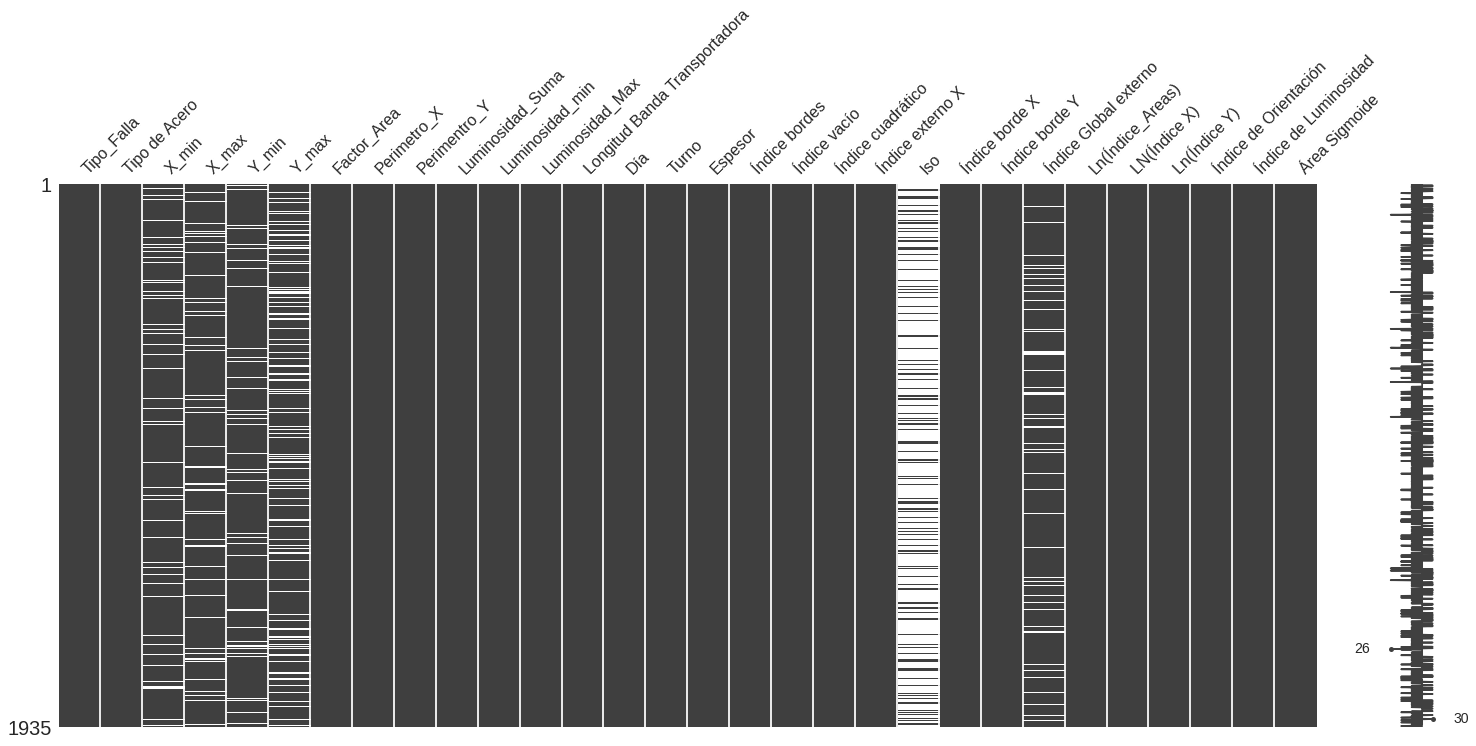

In [250]:
msno.matrix(df)

Se evidencia una considerable ausencia de atos en ISO, por lo que revisaremos el porcentaje de vacancias antes de la imputacion.

In [251]:
(df.isna().sum()/len(df)*100).to_frame().rename(columns = {0:"Porcentaje[%]"})

,Porcentaje[%]
Tipo_Falla,0.000
Tipo de Acero,0.000
X_min,6.202
X_max,9.819
Y_min,8.165
Y_max,15.556
Factor_Area,0.000
Perimetro_X,0.000
Perimentro_Y,0.000
Luminosidad_Suma,0.000


Al ser casi 80% de datos faltantes en ISO, se eliminara la columna.

In [252]:
df.drop("Iso", axis = 1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1935 entries, 0 to 1934
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Tipo_Falla                     1935 non-null   object 
 1   Tipo de Acero                  1935 non-null   int64  
 2   X_min                          1815 non-null   float64
 3   X_max                          1745 non-null   float64
 4   Y_min                          1777 non-null   float64
 5   Y_max                          1634 non-null   float64
 6   Factor_Area                    1935 non-null   float64
 7   Perimetro_X                    1935 non-null   int64  
 8   Perimentro_Y                   1935 non-null   int64  
 9   Luminosidad_Suma               1935 non-null   int64  
 10  Luminosidad_min                1935 non-null   int64  
 11  Luminosidad_Max                1935 non-null   int64  
 12  Longitud Banda Transportadora  1935 non-null   i

In [253]:
df2 = pd.get_dummies(df, columns = ["Tipo_Falla","Tipo de Acero","Día","Turno"])
df2

,X_min,X_max,Y_min,Y_max,Factor_Area,Perimetro_X,Perimentro_Y,Luminosidad_Suma,Luminosidad_min,Luminosidad_Max,...,Tipo de Acero_420,Tipo de Acero_431,Tipo de Acero_440,Día_Jueves,Día_Lunes,Día_Martes,Día_Miercoles,Día_Viernes,Turno_Dia,Turno_Noche
0,42.000,50.000,270900.000,270944.000,265.665,17,44,24220,76,108,...,0,0,0,0,0,0,1,0,0,1
1,645.000,651.000,2538079.000,2538108.000,109.620,10,30,11397,84,123,...,0,0,0,0,1,0,0,0,1,0
2,829.000,835.000,1553913.000,1553931.000,71.000,8,19,7972,99,125,...,0,0,0,0,0,0,0,1,0,1
3,853.000,860.000,369370.000,369415.000,176.000,13,45,18996,99,126,...,0,1,0,0,0,1,0,0,1,0
4,1289.000,1306.000,498078.000,NaN,2384.910,60,260,246930,37,126,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930,249.000,277.000,325780.000,325796.000,273.000,54,22,35033,119,141,...,0,0,0,0,1,0,0,0,0,1
1931,144.000,175.000,340581.000,NaN,292.740,44,24,34599,112,133,...,0,0,0,1,0,0,0,0,0,1
1932,145.000,174.000,386779.000,386794.000,289.080,40,22,37572,120,140,...,0,0,0,0,0,1,0,0,0,1
1933,137.000,170.000,422497.000,422528.000,416.905,97,47,52715,117,140,...,0,0,1,0,1,0,0,0,0,1


Se hallan las variables Dummies para las variables categoricas, siendo esto el tipo de acero, dia y el turno.

In [254]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1935 entries, 0 to 1934
Data columns (total 50 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   X_min                          1815 non-null   float64
 1   X_max                          1745 non-null   float64
 2   Y_min                          1777 non-null   float64
 3   Y_max                          1634 non-null   float64
 4   Factor_Area                    1935 non-null   float64
 5   Perimetro_X                    1935 non-null   int64  
 6   Perimentro_Y                   1935 non-null   int64  
 7   Luminosidad_Suma               1935 non-null   int64  
 8   Luminosidad_min                1935 non-null   int64  
 9   Luminosidad_Max                1935 non-null   int64  
 10  Longitud Banda Transportadora  1935 non-null   int64  
 11  Espesor                        1935 non-null   float64
 12  Índice bordes                  1935 non-null   i

In [255]:
imputer_KNN = KNNImputer(n_neighbors = 10, weights = 'uniform', metric = 'nan_euclidean')
df_KNN = pd.DataFrame(imputer_KNN.fit_transform(df2), columns = df2.columns)

In [256]:
df_KNN.isna().any()

X_min                            False
X_max                            False
Y_min                            False
Y_max                            False
Factor_Area                      False
Perimetro_X                      False
Perimentro_Y                     False
Luminosidad_Suma                 False
Luminosidad_min                  False
Luminosidad_Max                  False
Longitud Banda Transportadora    False
Espesor                          False
Índice bordes                    False
Índice vacío                     False
Índice cuadrático                False
Índice externo X                 False
Índice borde X                   False
Índice borde Y                   False
Índice Global externo            False
Ln(Índice_Areas)                 False
LN(Índice X)                     False
Ln(Índice Y)                     False
Índice de Orientación            False
Índice de Luminosidad            False
Área Sigmoide                    False
Tipo_Falla_Abolladuras   

# Separacion de datos y Modelos
Se deja una variable X con los datos de DF sin la salida que es el tipo de falla.


1.   Se crea una variable Y con los tipos de falla
2.   Se hace una separacion 25% test 75% train.



In [257]:
x = df_KNN.drop(["Tipo_Falla_Abolladuras","Tipo_Falla_Deformaciones","Tipo_Falla_Otras Fallas","Tipo_Falla_Rayones Multiples","Tipo_Falla_Rayones Simples","Tipo_Falla_Suciedad","Tipo_Falla_Superficie Opaca"], axis = 1)
x

,X_min,X_max,Y_min,Y_max,Factor_Area,Perimetro_X,Perimentro_Y,Luminosidad_Suma,Luminosidad_min,Luminosidad_Max,...,Tipo de Acero_420,Tipo de Acero_431,Tipo de Acero_440,Día_Jueves,Día_Lunes,Día_Martes,Día_Miercoles,Día_Viernes,Turno_Dia,Turno_Noche
0,42.000,50.000,270900.000,270944.000,265.665,17.000,44.000,24220.000,76.000,108.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000
1,645.000,651.000,2538079.000,2538108.000,109.620,10.000,30.000,11397.000,84.000,123.000,...,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000
2,829.000,835.000,1553913.000,1553931.000,71.000,8.000,19.000,7972.000,99.000,125.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000
3,853.000,860.000,369370.000,369415.000,176.000,13.000,45.000,18996.000,99.000,126.000,...,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000
4,1289.000,1306.000,498078.000,904403.600,2384.910,60.000,260.000,246930.000,37.000,126.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930,249.000,277.000,325780.000,325796.000,273.000,54.000,22.000,35033.000,119.000,141.000,...,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000
1931,144.000,175.000,340581.000,1167215.100,292.740,44.000,24.000,34599.000,112.000,133.000,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000
1932,145.000,174.000,386779.000,386794.000,289.080,40.000,22.000,37572.000,120.000,140.000,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000
1933,137.000,170.000,422497.000,422528.000,416.905,97.000,47.000,52715.000,117.000,140.000,...,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000


In [258]:
high_cor_function(x, 0.70)

max corr: 0.979717751386157 , min corr:  -1.0


Luminosidad_Suma  Factor_Area             0.980
Factor_Area       Perimetro_X             0.967
X_max             X_min                   0.922
Perimetro_X       Luminosidad_Suma        0.914
Perimentro_Y      Perimetro_X             0.913
Y_min             Y_max                   0.896
Perimentro_Y      Factor_Area             0.826
Luminosidad_Max   Índice de Luminosidad   0.785
Luminosidad_Suma  Perimentro_Y            0.706
dtype: float64

In [259]:
correlated_features = set()
correlation_matrix = x.corr()
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.75:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
print('Hay alta correlacion en: '+str(len(correlated_features))+' columnas que son: '+ str(correlated_features))

Hay alta correlacion en: 7 columnas que son: {'Perimentro_Y', 'X_max', 'Y_max', 'Perimetro_X', 'Índice de Luminosidad', 'Luminosidad_Suma', 'Turno_Noche'}


In [260]:
x2 = x.drop(["Perimetro_X","Perimentro_Y","X_max","X_min","Y_max","Y_min","Luminosidad_Suma",
             "Índice de Luminosidad","Luminosidad_Max","Turno_Noche",], axis='columns')
high_cor_function(x2, 0.75)

max corr: 0.5578114714268871 , min corr:  -0.4959529489868307


Series([], dtype: float64)

In [261]:
x2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1935 entries, 0 to 1934
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Factor_Area                    1935 non-null   float64
 1   Luminosidad_min                1935 non-null   float64
 2   Longitud Banda Transportadora  1935 non-null   float64
 3   Espesor                        1935 non-null   float64
 4   Índice bordes                  1935 non-null   float64
 5   Índice vacío                   1935 non-null   float64
 6   Índice cuadrático              1935 non-null   float64
 7   Índice externo X               1935 non-null   float64
 8   Índice borde X                 1935 non-null   float64
 9   Índice borde Y                 1935 non-null   float64
 10  Índice Global externo          1935 non-null   float64
 11  Ln(Índice_Areas)               1935 non-null   float64
 12  LN(Índice X)                   1935 non-null   f

In [262]:
y = df["Tipo_Falla"].values
y[:10]
y_dum = df2[["Tipo_Falla_Abolladuras","Tipo_Falla_Deformaciones","Tipo_Falla_Otras Fallas","Tipo_Falla_Rayones Multiples",
                "Tipo_Falla_Rayones Simples","Tipo_Falla_Suciedad","Tipo_Falla_Superficie Opaca"]].values

Clases = ["Abolladuras","Deformaciones","Otras Fallas","Rayones Multiples","Rayones Simples","Suciedad","Superficie Opaca"]

In [263]:
a = y_dum[:,1].astype(float)

In [264]:
df_full = x2
for i in range(len(Clases)):
  try:
    df_full.insert(i,Clases[i],y_dum[:,i].astype(float))
  except:
    pass
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1935 entries, 0 to 1934
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Abolladuras                    1935 non-null   float64
 1   Deformaciones                  1935 non-null   float64
 2   Otras Fallas                   1935 non-null   float64
 3   Rayones Multiples              1935 non-null   float64
 4   Rayones Simples                1935 non-null   float64
 5   Suciedad                       1935 non-null   float64
 6   Superficie Opaca               1935 non-null   float64
 7   Factor_Area                    1935 non-null   float64
 8   Luminosidad_min                1935 non-null   float64
 9   Longitud Banda Transportadora  1935 non-null   float64
 10  Espesor                        1935 non-null   float64
 11  Índice bordes                  1935 non-null   float64
 12  Índice vacío                   1935 non-null   f

In [265]:
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)
x_train, x_test, y_train, y_test = train_test_split(x2, y_dum, test_size = 0.25)
print(len(x_train), len(x_test))
print(len(y_train), len(y_test))
clss = []
for i in range(len(y_test)):
  clss.append(Clases[y_test.argmax(axis=1)[i]])

1451 484
1451 484


In [266]:
x_train.shape
columnas_x = x_train.columns
columnas_x

Index(['Abolladuras', 'Deformaciones', 'Otras Fallas', 'Rayones Multiples',
       'Rayones Simples', 'Suciedad', 'Superficie Opaca', 'Factor_Area',
       'Luminosidad_min', 'Longitud Banda Transportadora', 'Espesor',
       'Índice bordes        ', 'Índice vacío', 'Índice cuadrático',
       'Índice externo X', 'Índice borde X', 'Índice borde Y',
       'Índice Global externo', 'Ln(Índice_Areas)', 'LN(Índice X)',
       'Ln(Índice Y)', 'Índice de Orientación', 'Área Sigmoide',
       'Tipo de Acero_301', 'Tipo de Acero_302', 'Tipo de Acero_304',
       'Tipo de Acero_310', 'Tipo de Acero_316', 'Tipo de Acero_321',
       'Tipo de Acero_403', 'Tipo de Acero_416', 'Tipo de Acero_420',
       'Tipo de Acero_431', 'Tipo de Acero_440', 'Día_Jueves', 'Día_Lunes',
       'Día_Martes', 'Día_Miercoles', 'Día_Viernes', 'Turno_Dia'],
      dtype='object')

In [267]:
scaler = StandardScaler()

In [268]:
x_test.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 484 entries, 1866 to 1644
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Abolladuras                    484 non-null    float64
 1   Deformaciones                  484 non-null    float64
 2   Otras Fallas                   484 non-null    float64
 3   Rayones Multiples              484 non-null    float64
 4   Rayones Simples                484 non-null    float64
 5   Suciedad                       484 non-null    float64
 6   Superficie Opaca               484 non-null    float64
 7   Factor_Area                    484 non-null    float64
 8   Luminosidad_min                484 non-null    float64
 9   Longitud Banda Transportadora  484 non-null    float64
 10  Espesor                        484 non-null    float64
 11  Índice bordes                  484 non-null    float64
 12  Índice vacío                   484 non-null   

In [269]:
print(x_train.shape)
print(x_test.shape)

(1451, 40)
(484, 40)


In [270]:
#############
x_train = np.concatenate((scaler.fit_transform(x_train[columnas_x[0:22]]),
                          x_train[columnas_x[22:40]].to_numpy()),
                          axis = 1)
pd.DataFrame(x_train, columns = columnas_x)

,Abolladuras,Deformaciones,Otras Fallas,Rayones Multiples,Rayones Simples,Suciedad,Superficie Opaca,Factor_Area,Luminosidad_min,Longitud Banda Transportadora,...,Tipo de Acero_416,Tipo de Acero_420,Tipo de Acero_431,Tipo de Acero_440,Día_Jueves,Día_Lunes,Día_Martes,Día_Miercoles,Día_Viernes,Turno_Dia
0,-0.511,-0.187,-0.717,-0.512,-0.346,-0.173,3.474,-0.303,-0.259,1.569,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
1,-0.511,-0.187,1.394,-0.512,-0.346,-0.173,-0.288,-0.321,1.039,1.569,...,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
2,-0.511,-0.187,1.394,-0.512,-0.346,-0.173,-0.288,0.764,0.081,-0.735,...,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000
3,-0.511,5.349,-0.717,-0.512,-0.346,-0.173,-0.288,-0.339,0.235,-0.687,...,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
4,-0.511,-0.187,1.394,-0.512,-0.346,-0.173,-0.288,-0.326,2.368,-0.735,...,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,1.959,-0.187,-0.717,-0.512,-0.346,-0.173,-0.288,-0.233,-1.248,1.589,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000
1447,1.959,-0.187,-0.717,-0.512,-0.346,-0.173,-0.288,-0.340,0.205,1.148,...,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
1448,1.959,-0.187,-0.717,-0.512,-0.346,-0.173,-0.288,-0.209,-0.228,-0.673,...,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
1449,-0.511,-0.187,-0.717,1.955,-0.346,-0.173,-0.288,-0.333,1.966,-0.501,...,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000


In [271]:
x_test = np.concatenate((scaler.fit_transform(x_test[columnas_x[0:22]]),
                          x_test[columnas_x[22:40]].to_numpy()),
                          axis = 1)
pd.DataFrame(x_train, columns = columnas_x)

,Abolladuras,Deformaciones,Otras Fallas,Rayones Multiples,Rayones Simples,Suciedad,Superficie Opaca,Factor_Area,Luminosidad_min,Longitud Banda Transportadora,...,Tipo de Acero_416,Tipo de Acero_420,Tipo de Acero_431,Tipo de Acero_440,Día_Jueves,Día_Lunes,Día_Martes,Día_Miercoles,Día_Viernes,Turno_Dia
0,-0.511,-0.187,-0.717,-0.512,-0.346,-0.173,3.474,-0.303,-0.259,1.569,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
1,-0.511,-0.187,1.394,-0.512,-0.346,-0.173,-0.288,-0.321,1.039,1.569,...,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
2,-0.511,-0.187,1.394,-0.512,-0.346,-0.173,-0.288,0.764,0.081,-0.735,...,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000
3,-0.511,5.349,-0.717,-0.512,-0.346,-0.173,-0.288,-0.339,0.235,-0.687,...,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
4,-0.511,-0.187,1.394,-0.512,-0.346,-0.173,-0.288,-0.326,2.368,-0.735,...,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,1.959,-0.187,-0.717,-0.512,-0.346,-0.173,-0.288,-0.233,-1.248,1.589,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000
1447,1.959,-0.187,-0.717,-0.512,-0.346,-0.173,-0.288,-0.340,0.205,1.148,...,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
1448,1.959,-0.187,-0.717,-0.512,-0.346,-0.173,-0.288,-0.209,-0.228,-0.673,...,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
1449,-0.511,-0.187,-0.717,1.955,-0.346,-0.173,-0.288,-0.333,1.966,-0.501,...,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000


# MODELOS NN
De arquitectura propia.




In [272]:
x_test.shape[1]

40

In [273]:

print('La dimension de x_train: '+str(x_train.shape)+' y de y_train: '+str(y_train.shape))
np.reshape(x_train, 
           (x_train.shape[0],x_train.shape[1]))
np.reshape(y_train,
           (y_train.shape[0],y_train.shape[1]))
np.reshape(x_test,
           (x_test.shape[0],x_test.shape[1]))
np.reshape(y_test,
           (y_test.shape[0],y_test.shape[1]))
#print(x_train.shape)
#x_train = np.repeat(x_train[..., np.newaxis], 1, -1)
#x_test = np.repeat(x_test[..., np.newaxis], 1, -1)
#y_train = np.repeat(y_train[..., np.newaxis], 1, -1)
#y_test = np.repeat(y_test[..., np.newaxis], 1, -1)
print(x_train.shape)
print(x_test.shape)

La dimension de x_train: (1451, 40) y de y_train: (1451, 7)
(1451, 40)
(484, 40)


## Primer modelo

In [274]:
EPOCAS = 10
clf_atk = ak.StructuredDataClassifier(overwrite=True, max_trials=2)
clf_atk.fit(x_train, y_train, epochs=EPOCAS)

Trial 2 Complete [00h 00m 21s]
val_accuracy: 0.4681648015975952

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 00m 34s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
46/46 [==============================] - 1s 7ms/step - loss: 1.6646 - accuracy: 0.3742
Epoch 2/10
46/46 [==============================] - 0s 7ms/step - loss: 1.0095 - accuracy: 0.7595
Epoch 3/10
46/46 [==============================] - 0s 7ms/step - loss: 0.5124 - accuracy: 0.8939
Epoch 4/10
46/46 [==============================] - 0s 6ms/step - loss: 0.2263 - accuracy: 0.9614
Epoch 5/10
46/46 [==============================] - 0s 7ms/step - loss: 0.1055 - accuracy: 0.9910
Epoch 6/10
46/46 [==============================] - 0s 6ms/step - loss: 0.0556 - accuracy: 0.9972
Epoch 7/10
46/46 [==============================] - 0s 7ms/step - loss: 0.0322 - accuracy: 0.9993
Epoch 8/10
46/46 [==============================] - 0s 6ms/step - loss: 0.0202 - accuracy: 1.0000
Epoch 9/10
46/46 [==============================] -

In [277]:
loss, acc = clf_atk.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)
predicted_y = clf_atk.predict(x_test)
print(predicted_y.shape)
print(y_test.shape)

Accuracy: 0.370
16/16 [==============================] - 0s 6ms/step
(484, 7)
(484, 7)


----------------------------------------------------------------


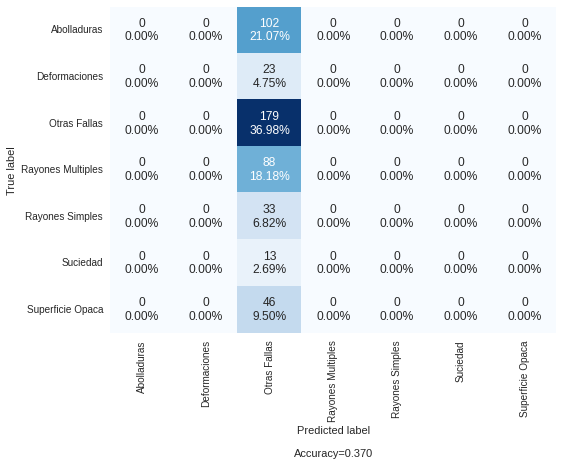

In [280]:
confussion_mat_autokeras = confusion_matrix (y_test.argmax(axis=1) , predicted_y.argmax(axis=1))
make_confusion_matrix( cf =confussion_mat_autokeras, categories= Clases,figsize=(8,6), cbar=False)
print('----------------------------------------------------------------')

In [ ]:
y_train

# Exportacion de Modelos
  1. Al ser los priemros 3 modelos de ScikitLearn se guardan como .sav con ayuda de joblib
  2. El modelo de Autokeras se salva en formato .pb como un modelo de Tensorflow normal, hay que tener encuenta que al cargar el modelo hay que indicarle que es un modelo de Autokeras.

In [ ]:
ruta  = "/content/gdrive/MyDrive/Modelos_IF_MP6/"
n_atk = ruta + 'autokeras/' + str(clf_atk) + '.h5'
model = clf_atk.export_model()
try:
    model.save(ruta+"model_autokeras", save_format="tf")
except Exception:
    model.save(ruta+"model_autokeras.h5")

# Dataset para pruebas
En esta seccion se procede a buscar el tipo de falla de un dataset de prueba, por lo que igualmente hay que cargar el dataset y luego de esto dejarlo en un formato de entrada para los 4 diferentes modelos de ML.

In [ ]:
df = pd.read_excel("/content/gdrive/MyDrive/Datos_Casos_Prueba.xlsx")
df.head(5)

In [ ]:
df.info()

In [ ]:
df.drop("Iso", axis = 1, inplace = True)

In [ ]:
df["Turno"].replace({'Día':'Dia','    Noche':'Noche',' ':''}, inplace = True)
df["Día"].replace({'Marte':'Martes','Miércoles':'Miercoles',}, inplace = True)

In [ ]:
df["Día"].value_counts()

In [ ]:
df["Turno"].value_counts()

In [ ]:
df.rename(columns = {'         Perimentro_Y' :'Perimentro_Y','        Índice borde X':'Índice borde X','       Índice de Orientación':'Índice de Orientación'}, inplace = True)

In [ ]:
df.describe(include = 'O')

In [ ]:
df2 = pd.get_dummies(df, columns = ["Tipo de Acero","Día","Turno"])
df2.head(5)

In [ ]:
df2.isna().any()

In [ ]:
Clases = ["Abolladuras","Deformaciones","Otras Fallas","Rayones Multiples",
                "Rayones Simples","Suciedad","Superficie Opaca"]
try:
  df2.insert(26, "Tipo de Acero_301", 0, allow_duplicates=False)
  df2.insert(27, "Tipo de Acero_302", 0, allow_duplicates=False)
  df2.insert(28, "Tipo de Acero_316", 0, allow_duplicates=False)
  df2.insert(29, "Tipo de Acero_416", 0, allow_duplicates=False)
except:
  pass
columnas_x = df2.columns
columnas_x
X = df2
scaler = StandardScaler()
df2.info()

In [ ]:
X = np.concatenate((scaler.fit_transform(X[["X_min", "X_max","Y_min","Y_max","Factor_Area","Perimetro_X","Perimentro_Y","Luminosidad_Suma","Luminosidad_min","Luminosidad_Max",
                                                        "Longitud Banda Transportadora","Espesor","Índice bordes        ","Índice vacío","Índice cuadrático","Índice externo X","Índice borde X",
                                                        "Índice borde Y","Índice Global externo","Ln(Índice_Areas)","LN(Índice X)","Ln(Índice Y)","Índice de Orientación","Índice de Luminosidad",
                                                        "Área Sigmoide"]]),
                        X["Tipo de Acero_301"].to_numpy().reshape(len(X),1),
                        X["Tipo de Acero_302"].to_numpy().reshape(len(X),1),
                        X["Tipo de Acero_304"].to_numpy().reshape(len(X),1),
                        X["Tipo de Acero_310"].to_numpy().reshape(len(X),1),
                        X["Tipo de Acero_316"].to_numpy().reshape(len(X),1),
                        X["Tipo de Acero_321"].to_numpy().reshape(len(X),1),
                        X["Tipo de Acero_403"].to_numpy().reshape(len(X),1),
                        X["Tipo de Acero_416"].to_numpy().reshape(len(X),1),
                        X["Tipo de Acero_420"].to_numpy().reshape(len(X),1),
                        X["Tipo de Acero_431"].to_numpy().reshape(len(X),1),
                        X["Tipo de Acero_440"].to_numpy().reshape(len(X),1),
                        X["Día_Jueves"].to_numpy().reshape(len(X),1),
                        X["Día_Lunes"].to_numpy().reshape(len(X),1),
                        X["Día_Martes"].to_numpy().reshape(len(X),1),
                        X["Día_Miercoles"].to_numpy().reshape(len(X),1),
                        X["Día_Viernes"].to_numpy().reshape(len(X),1),
                        X["Turno_Dia"].to_numpy().reshape(len(X),1),
                        X["Turno_Noche"].to_numpy().reshape(len(X),1)), axis = 1)
pd.DataFrame(X, columns = columnas_x)

Una vez ya el dataset esta en un formato correcto para hacer predicciones en cada modelo, se procede a cargar los diferentes modelos desde sus respectivas funciones y librerias.

In [ ]:
model_logreg = joblib.load("/content/gdrive/MyDrive/Modelos_IF_MP3/reg_log.sav")
model_knn = joblib.load("/content/gdrive/MyDrive/Modelos_IF_MP3/clf_knn.sav")
model_rf = joblib.load("/content/gdrive/MyDrive/Modelos_IF_MP3/clf_rf.sav")
model_svm = joblib.load("/content/gdrive/MyDrive/Modelos_IF_MP3/clf_svm.sav")
model_nn = tf.keras.models.load_model("/content/gdrive/MyDrive/Modelos_IF_MP3/model_autokeras/",
                                      custom_objects=ak.CUSTOM_OBJECTS)

In [ ]:
Yp_log = model_logreg.predict(X)
Yp_knn = model_knn.predict(X)
Yp_rf = model_rf.predict(X)
Yp_svm = model_svm.predict(X)
predictions_nn = model_nn.predict(tf.expand_dims(X, -1))
Yp_nn = []
for i in range(len(predictions_nn)):
  Yp_nn.append(Clases[predictions_nn.argmax(axis=1)[i]])
Yp_nn

Para el modelo de TF, es importante guardar cada valor guardado en las perdicciones, por eso se requiere un for y una lista.

# Resultados

Se procede a crear un DataFrame con los resultados de los modelos, de esta manera vemos de manera inicial que predijo cada modelo en cada situacion.

In [ ]:
Resultados = pd.DataFrame()
Resultados["Regresion logistica"] = Yp_log
Resultados["Clasificador KNN"] = Yp_knn
Resultados["SGD Clasiffier"] = Yp_rf
Resultados["NeuralNetwork Autokeras"] = Yp_nn
Resultados["Support Vector Machine"] = Yp_svm
Resultados.head(14)

In [ ]:
md = Resultados.mode(axis=1)
md[0]

Se Halla la moda de cada fila, asi bajo un criterio de "el que mas haya" en la fila sera la desicion tomada como criterio final.

In [ ]:
Resultados["Desicion Final"] = md[0]
Resultados.head(14)

In [ ]:
ren_pc = []
cont = 0
for cols in Resultados.columns:
  cont = 0
  for fila in range(len(Resultados[cols])):
    if Resultados.iloc[fila][cols] == Resultados.iloc[fila]["Desicion Final"]:
      cont += 1
  ren_pc.append((cont/len(Resultados["Desicion Final"]))*100)
mj_model = pd.DataFrame()
ren_pc.pop()
mj_model["Modelo"] = ['Regresion Logistica','Stochastic Gradient Descent','K-Nearest Neighbor','Neural Network','Support Vector Machine']
mj_model["Rendimiento"] = ren_pc
mj_model

El mejor modelo es la **Red Neuronal Densa**, acertando todas las desiciones bajo el criterio de moda entre todos los modelos.

De extra, este DF de resultados se guarda en un .csv para futuras visualizaciones.

In [ ]:
ruta = "/content/gdrive/MyDrive/Modelos_IF_MP3/"
Resultados.to_csv(ruta+'results.csv')